[View in Colaboratory](https://colab.research.google.com/github/Naren-Jegan/Deep-Learning-Keras/blob/master/MIAS%20Classifier.ipynb)

In [1]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [0]:
from google.colab import auth
auth.authenticate_user()

In [3]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
# Work around misordering of STREAM and STDIN in Jupyter.
# https://github.com/jupyter/notebook/issues/3159
prompt = !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass(prompt[0] + '\n\nEnter verification code: ')
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force

Enter verification code: ··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os
from PIL import Image
import random
import pickle

In [0]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

In [7]:
tf.__version__

'1.9.0'

In [0]:
#path = os.path.join('drive','Colab Notebooks', 'mammogram')
#targets = []
data = []
#one_hot_encoding = {1 : [1, 0, 0 ], 2 : [0, 1, 0 ], 3 : [0, 0, 1 ]}
#with open(os.path.join('drive','Colab Notebooks', 'classes.file'), 'rb') as f:
#  targets = pickle.load(f)
#noshape = True
#for imagefile in os.listdir(path):
#  image = Image.open(os.path.join(path, imagefile))
#  image_data = np.array(image)
#  if noshape:
#    shape = image_data.shape
#    noshape = False
#  target = targets[int(imagefile[3:5])]
#  data.append([image_data.ravel(), target, one_hot_encoding[target]])
#with open(os.path.join('drive','Colab Notebooks', 'miasdata.file'), 'wb') as f:
#  pickle.dump({'shape' : shape, 'data' : data}, f)
with open(os.path.join('drive','Colab Notebooks', 'miasdata.file'), 'rb') as f:
  data = pickle.load(f)
shape = data['shape']
data = data['data']

In [0]:
random.shuffle(data)

In [10]:
if len(shape) is not 3:
  shape += (1,)
  print(shape)

(1024, 1024, 1)


In [0]:
img_size = shape[0]
img_size_flat = shape[0]*shape[1]
img_shape = (shape[0], shape[1])
img_shape_full = shape
num_classes = 3
num_channels = shape[2]

In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [13]:
num_train = int(len(data)*0.80)
train_data = data[0:num_train-1]
leftover_data = data[num_train:]
num_test = int(len(leftover_data)*0.50)
test_data = leftover_data[0:num_test - 1]
validation_data = leftover_data[num_test:]
num_validation = len(validation_data)
print("training set: " + str(num_train))
print("test set: " + str(num_test))
print("validation set: " + str(num_validation))

training set: 257
test set: 32
validation set: 33


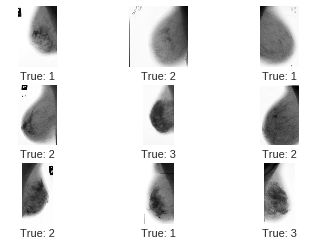

In [14]:
# Get the first images from the test-set.
images = [test_data[i][0] for i in range(9)]
# Get the true classes for those images.
cls_true = [test_data[i][1] for i in range(9)]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [0]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != data.y_test_cls)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.y_test_cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [0]:
# Start construction of the Keras Sequential model.
model = Sequential()

# Add an input layer which is similar to a feed_dict in TensorFlow.
# Note that the input-shape must be a tuple containing the image-size.
model.add(InputLayer(input_shape=(img_size_flat,)))

# The input is a flattened array with 1048576 elements,
# but the convolutional layers expect images with shape (1024, 1024)
model.add(Reshape(img_shape_full))

# First convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=2, filters=16, padding='valid',
                 activation='relu', name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Second convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=2, filters=32, padding='valid',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Third convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=3, strides=2, filters=64, padding='valid',
                 activation='relu', name='layer_conv3'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Fourth convolutional layer with ReLU-activation and max-pooling.
model.add(Conv2D(kernel_size=5, strides=2, filters=128, padding='valid',
                 activation='relu', name='layer_conv4'))
model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten the 4-rank output of the convolutional layers
# to 2-rank that can be input to a fully-connected / dense layer.
model.add(Flatten())

# First fully-connected / dense layer with ReLU-activation.
model.add(Dense(128, activation='relu', name = "dense_1"))

# Last fully-connected / dense layer with softmax-activation
# for use in classification.
model.add(Dense(num_classes, activation='softmax', name = "dense_2"))

In [0]:
from tensorflow.python.keras.optimizers import Adam

optimizer = Adam(lr=1e-3)

In [0]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=15)

In [35]:
model.fit(x=np.array([td[0]/255 for td in train_data]),
          y=np.array([td[2] for td in train_data]),
          batch_size=10, shuffle = True,
          epochs=25,#1000,
          validation_data = (np.array([td[0]/255 for td in validation_data]), np.array([td[2] for td in validation_data])),
          callbacks=[early_stopping]
         )

Train on 256 samples, validate on 33 samples
Epoch 1/25
256/256 [==============================] - 4s 16ms/step - loss: 0.9088 - acc: 0.4258 - val_loss: 1.0170 - val_acc: 0.4545
Epoch 2/25
256/256 [==============================] - 3s 13ms/step - loss: 0.8585 - acc: 0.5469 - val_loss: 1.0241 - val_acc: 0.4545
Epoch 3/25
256/256 [==============================] - 3s 13ms/step - loss: 0.8773 - acc: 0.5508 - val_loss: 1.0990 - val_acc: 0.4545
Epoch 4/25
256/256 [==============================] - 3s 13ms/step - loss: 0.8787 - acc: 0.4805 - val_loss: 1.0596 - val_acc: 0.4545
Epoch 5/25
256/256 [==============================] - 3s 13ms/step - loss: 0.8473 - acc: 0.5313 - val_loss: 1.0576 - val_acc: 0.4545
Epoch 6/25
256/256 [==============================] - 3s 13ms/step - loss: 0.8677 - acc: 0.5234 - val_loss: 1.2132 - val_acc: 0.3939
Epoch 7/25
256/256 [==============================] - 3s 13ms/step - loss: 0.8449 - acc: 0.5703 - val_loss: 1.1995 - val_acc: 0.4848
Epoch 8/25
256/256 [====

In [36]:
result = model.evaluate(x=np.array([td[0]/255 for td in test_data]),
                        y=np.array([td[2] for td in test_data]))

31/31 [==============================] - 0s 8ms/step


In [37]:
for name, value in zip(model.metrics_names, result):
    print(name, value)
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

loss 0.8724645972251892
acc 0.5806451439857483
acc: 58.06%


[1, 2, 1, 1, 1, 1, 2, 1, 1]


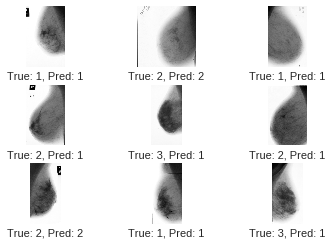

In [24]:
# Get the first images from the test-set.
images = np.array([test_data[i][0]/255 for i in range(9)])
# Get the true classes for those images.
cls_true = np.array([test_data[i][1] for i in range(9)])

y_pred = model.predict(x=images)
cls_pred = [x + 1 for x in np.argmax(y_pred, axis=1)]
print(cls_pred)

plot_images(images=images,
            cls_true=cls_true,
            cls_pred=cls_pred)